# Dogs breed classifier

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# Install required packages 
!pip3 install smdebug --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 206.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
#Install required packages for deployment
!pip3 install torch torchvision --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 187.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 190.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 147.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 158.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 290.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 193.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
#!pip3 install plotly --no-cache-dir


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Import required packages
import sagemaker
import boto3

# Required packages for Hyperparameter tuning
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# Required packages for training and deployment
from sagemaker.pytorch import (
    PyTorch, 
    PyTorchModel
)

# Required packages for debugging and profiling
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerConfig, 
    FrameworkProfile,
    CollectionConfig
)

## 1. Dataset
The dataset being used contains RGB images of dogs belonging to 133 different breeds. It contains a total number of 8352 images. Approximately 80% of the images are provided for training and the remaining 20% are equally split for validation and testing purpose.

In [2]:
#Fetch and upload the data to AWS S3

# Command to download and unzip data (This command needs to be executed once)
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-23 07:30:34--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.136
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  39.6MB/s    in 28s     

2023-02-23 07:31:11 (38.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [5]:
#Set Sagemaker variables
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()

In [6]:
#Ensure Sagemaker variable values are correctly set
print("Default Bucket: {}".format(bucket))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-678784019262
RoleArn: arn:aws:iam::678784019262:role/service-role/AmazonSageMaker-ExecutionRole-20230223T072359


In [7]:
#Define the path to which the images are to be uploaded in S3
prefix = "project-3/data/dog-images"

In [ ]:
#Command to Upload data to S3 (This command needs to be executed once)
inputs = session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-678784019262/project-3/data/dog-images


In [8]:
#Set S3 path containing the dataset for further runs
inputs = "s3://sagemaker-us-east-1-678784019262/project-3/data/dog-images"

## 2. Hyperparameter Tuning
Attempting to find the best possible values for learning rate, batch size and epochs to be executed for training a good dog images classifier. From experience these values seems to have the capacity to drastically impact the predictive power of the model.

Using the `hpo.py` script to perform hyperparameter tuning.

In [10]:
#Declare the HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size" : CategoricalParameter([128, 256, 512]),
    "epochs" : IntegerParameter(7, 10)
}

In [11]:
#Create estimators for Hyperparameters (HP)
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    #max_runtime_in_seconds=2400,
    objective_type=objective_type,
    early_stopping_type="Auto"
)

In [12]:
# Perform HP tuning
tuner.fit({"train": inputs+"/train/", 
"valid": inputs+"/valid/",
"test": inputs+"/test/"
})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# Attaching the best previously completed training job
tuner = HyperparameterTuner.attach("pytorch-training-230227-1141")

In [12]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()
print(f"Best estimator is: {best_estimator._current_job_name}")

# Get the hyperparameters of the best trained model
best_hp = best_estimator.hyperparameters()

# Print the best hyperparameters
print(f"Best hyperparameters are: {best_hp}")


2023-02-27 12:20:08 Starting - Preparing the instances for training
2023-02-27 12:20:08 Downloading - Downloading input data
2023-02-27 12:20:08 Training - Training image download completed. Training in progress.
2023-02-27 12:20:08 Uploading - Uploading generated training model
2023-02-27 12:20:08 Completed - Resource released due to keep alive period expiry
Best estimator is: pytorch-training-230227-1141-002-e5ebfecc
Best hyperparameters are: {'_tuning_objective_metric': '"average test loss"', 'batch-size': '"128"', 'epochs': '9', 'lr': '0.00711527529031811', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2023-02-27-11-41-06-534"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-678784019262/pytorch-training-2023-02-27-11-41-06-534/source/sourcedir.tar.gz"'}


In [36]:
# Save the best identified values into best_hyperparameters variable
best_hyperparameters = {
    "batch-size": int(best_hp["batch-size"].replace('"', "")),
    "epochs": best_hp["epochs"],
    "lr": best_hp["lr"]
}

## 3. Model Profiling and Debugging
Using the best hyperparameters, creating and finetuning a new model.

Using the `train_model.py` script to perform model profiling and debugging while finetuning the model to detect any issues in performance or training early on.

In [37]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

# Make sure to set this to your bucket and location
BUCKET_NAME = bucket
LOCATION_IN_BUCKET = "project-3/dogBreed-tensor-plot"
s3_bucket_for_tensors = "s3://{BUCKET_NAME}/{LOCATION_IN_BUCKET}".format(
    BUCKET_NAME=BUCKET_NAME, LOCATION_IN_BUCKET=LOCATION_IN_BUCKET
)

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "10"},
    s3_output_path=s3_bucket_for_tensors,  # Required
    collection_configs=[
            CollectionConfig(
                name="CrossEntropyLoss_output", parameters={"include_regex": "CrossEntropyLoss_output.*", 
                                                            "train.save_interval": "10", 
                                                            "eval.save_interval": "10",
                                                            "predict.save_interval": "10"}
            )
        ]        
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [38]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="sagemaker-script-mode",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters=best_hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    ## Profiler parameters
    profiler_config=profiler_config
)

In [39]:
estimator.fit({"train": inputs+"/train/", 
"valid": inputs+"/valid/",
"test": inputs+"/test/"
})

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-03-02 10:44:32 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-02 10:46:00 Starting - Preparing the instances for training......
2023-03-02 10:46:57 Downloading - Downloading input data......
2023-03-02 10:48:04 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-02 10:48:11,391 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-02 10:48:11,394 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-02 10:48:11,403 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-02 10:48:11,405 sagemaker_pytorch_container.training I

In [41]:
# Plot a debugging output

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

tensors_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(tensors_path)

print(f"Tensor names are: {trial.collections}")
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-03-02 11:29:34.277 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-678784019262/project-3/dogBreed-tensor-plot/sagemaker-script-mode-2023-03-02-10-44-31-991/debug-output
Tensor names are: <bound method Trial.collections of <smdebug.trials.s3_trial.S3Trial object at 0x7fdc4df1f610>:(
    name=debug-output,
    path=s3://sagemaker-us-east-1-678784019262/project-3/dogBreed-tensor-plot/sagemaker-script-mode-2023-03-02-10-44-31-991/debug-output/,
    steps=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 477],
    collections=['losses', 'default', 'gradients', 'biases', 'weights', 'all', 'relu_input', 'CrossEntropyLoss_output'],
    tensor_names=['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/R

In [27]:
import os

# Download Tesor from S3
folder_name = tensors_path.split("/")[-1]
os.system("aws s3 cp --recursive " + tensors_path + " " + folder_name)
print("Downloaded tensors into folder: ", folder_name)

Downloaded tensors into folder:  debug-output


In [26]:
# Plot
import tensor_plot

visualization = tensor_plot.TensorPlot(
    regex=".*",
    path=folder_name,
)



[2023-03-02 09:56:10.558 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO local_trial.py:35] Loading trial debug-output at path debug-output


IndexError: list index out of range

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [38]:
#DEnsuring Profiler data from system is available
training_job_name = estimator.latest_training_job.name
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ImportError: cannot import name 'Markup' from 'jinja2' (/opt/conda/lib/python3.7/site-packages/jinja2/__init__.py)

In [ ]:
#Display the profiler output
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

In [39]:
#Preparing to display the profiler report
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

You will find the profiler report in s3://sagemaker-us-east-1-678784019262/sagemaker-script-mode-2023-02-24-08-49-57-557/rule-output


In [43]:
#Display the profiler report
import IPython

IPython.display.HTML(filename=rule_output_path +"/"+ profiler_report_name + "/profiler-output/profiler-report.html")

FileNotFoundError: [Errno 2] No such file or directory: 's3://sagemaker-us-east-1-678784019262/sagemaker-script-mode-2023-02-24-08-49-57-557/rule-output/ProfilerReport/profiler-output/profiler-report.html'

## Model Deploying

In [5]:
# installing these as they'll be needed for inference
!pip3 install torch torchvision --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 176.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 198.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 149.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 162.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 182.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 302.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
#Preparing for model deployment
estimator = PyTorch.attach("sagemaker-script-mode-2023-02-24-08-49-57-557")

model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")


2023-02-24 09:12:15 Starting - Preparing the instances for training
2023-02-24 09:12:15 Downloading - Downloading input data
2023-02-24 09:12:15 Training - Training image download completed. Training in progress.
2023-02-24 09:12:15 Uploading - Uploading generated training model
2023-02-24 09:12:15 Completed - Training job completed
Model: s3://sagemaker-us-east-1-678784019262/sagemaker-script-mode-2023-02-24-08-49-57-557/output/model.tar.gz


In [4]:
# Deploy your model to an endpoint
# predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


2023-02-24 09:12:15 Starting - Preparing the instances for training
2023-02-24 09:12:15 Downloading - Downloading input data
2023-02-24 09:12:15 Training - Training image download completed. Training in progress.
2023-02-24 09:12:15 Uploading - Uploading generated training model
2023-02-24 09:12:15 Completed - Training job completed
-------------!

In [12]:
from sagemaker.pytorch.model import PyTorchModel
# Add Model Loader
model = PyTorchModel(
    entry_point="inference.py",
    role=role,
    model_data=model_data,
    framework_version="1.8",
    py_version="py36",
)

# Deploy
predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

## Testing Deployment

In [8]:
# installing these as they'll be needed for inference
!pip3 install torch torchvision --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 193.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 197.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 210.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 298.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 216.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 202.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
# Run an prediction on the endpoint
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [13]:
predictor = sagemaker.pytorch.model.PyTorchPredictor("pytorch-inference-2023-02-25-06-22-02-556")

In [14]:
# TODO: Predict function that takes in an image, preprocesses it, and uses the endpoint for prediction
def predict(image_path):
    image = Image.open(image_path)

    transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
        ])

    preprocessed_image = transform(image).unsqueeze(0)
    preprocessed_image = preprocessed_image.to("cpu")

    response = predictor.predict(preprocessed_image)
    pred = np.argmax(response, 1)
    plt.imshow(Image.open(image_path))
    plt.show()
    print(f"Actual: {image_path[15:18]}, Prediction: {pred[0]}")

tensor([[[[0.1412, 0.1725, 0.1882,  ..., 0.1255, 0.1255, 0.1216],
          [0.1569, 0.1922, 0.1882,  ..., 0.1255, 0.1294, 0.1255],
          [0.1765, 0.1922, 0.1922,  ..., 0.1255, 0.1216, 0.1294],
          ...,
          [0.3608, 0.3569, 0.3882,  ..., 0.4863, 0.4863, 0.4745],
          [0.3490, 0.3569, 0.3804,  ..., 0.4549, 0.4706, 0.4824],
          [0.3412, 0.3529, 0.3882,  ..., 0.4431, 0.4510, 0.4667]],

         [[0.0784, 0.0784, 0.0745,  ..., 0.0667, 0.0706, 0.0706],
          [0.0824, 0.0824, 0.0784,  ..., 0.0667, 0.0706, 0.0706],
          [0.0824, 0.0863, 0.0863,  ..., 0.0667, 0.0706, 0.0706],
          ...,
          [0.0980, 0.0980, 0.1176,  ..., 0.2706, 0.2824, 0.2863],
          [0.0941, 0.1020, 0.1176,  ..., 0.2000, 0.2196, 0.2353],
          [0.0902, 0.0980, 0.1176,  ..., 0.1882, 0.2039, 0.2275]],

         [[0.0392, 0.0314, 0.0235,  ..., 0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0275,  ..., 0.0353, 0.0353, 0.0392],
          [0.0314, 0.0314, 0.0275,  ..., 0

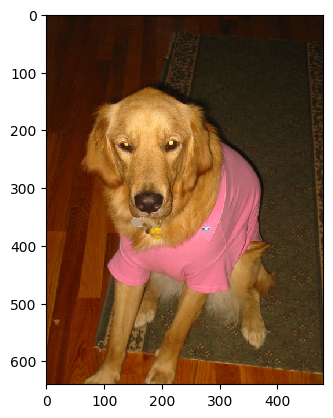

Actual: do, Prediction: 96


In [15]:
image_path = "dogImages/test/076.Golden_retriever/Golden_retriever_05241.jpg"
predict(image_path)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [17]:
print(image_path[:])

dogImages/test/076.Golden_retriever/Golden_retriever_05241.jpg
